In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
from torchsde import BrownianInterval, sdeint

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(ts, samples, xlabel, ylabel, title=''):
    ts = ts.cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure()
    for i, sample in enumerate(samples):
        plt.plot(ts, sample, marker='x', label=f'sample {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [3]:
bm = BrownianInterval(t0=0., t1=1., size=(4, 1))
dW = bm(0.2, 0.3)

In [4]:
class BMSphere(torch.nn.Module):
    def __init__(self, dim, radius):
        super().__init__()
        self.noise_type = "additive"
        self.sde_type = "ito"
        self.dim = dim
        self.radius = radius

    def f(self, t, y):
        """ Drift
        """
        return (2*1.-(self.dim+1.))*y/2.
    
    def g(self, t, y):
        """ Diffusion
        """
        return (torch.eye(self.dim).unsqueeze(0)*self.radius - torch.einsum('...i,...j->...ij', y, y)/self.radius)

In [7]:
radius = 2.
dim = 2
batch_size, state_size, t_size = 3, dim, 10000
sde = BMSphere(dim, radius)
ts = torch.linspace(0, 1, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=radius/np.sqrt(dim))

assert(torch.abs(y0[0,0]**2+y0[0,1]**2 - radius**2)<0.01)

with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='srk')  # (t_size, batch_size, state_size) = (100, 3, 1).

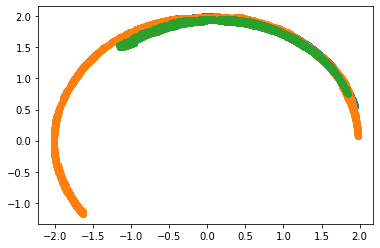

In [8]:
for b in range(batch_size):
    plt.scatter(ys[:,b,0], ys[:,b,1])

plt.show()

In [9]:
class KineticBrownianHyperbolicPlane(torch.nn.Module):
    def __init__(self, omega=0.):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.omega = omega

    def f(self, t, y):
        """ Drift
        """
        dx = y[:,2]
        dy = y[:,3]
        ddx = 2.* y[:,2]*y[:,3]/y[:,1]\
            - self.omega**2/2 * y[:,2]
        ddy = (y[:,3]**2 - y[:,2]**2)/y[:,1]\
            - self.omega**2/2 * y[:,3]
        return torch.stack((dx, dy, ddx, ddy), dim=-1)
    
    def g(self, t, y):
        """ Diffusion
        """
        return torch.stack((
            torch.zeros_like(y[:,0]),
            torch.zeros_like(y[:,1]),
            self.omega * y[:,3],
            - self.omega * y[:,2]
        ), dim=-1)

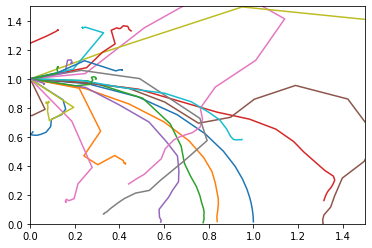

In [321]:
omega_list = np.arange(0, 5, 0.2)
t_size = 20
ys = {}

for omega in omega_list:
    sde = KineticBrownianHyperbolicPlane(omega)
    ts = torch.linspace(0, 5., t_size)
    y0 = torch.tensor([[0., 1., 1., 0.]])

    with torch.no_grad():
        ys[omega] = torchsde.sdeint(sde, y0, ts, method='srk')

for omega in omega_list:
    plt.plot(ys[omega][:,0,0], ys[omega][:,0,1])
plt.xlim(0., 1.5)
plt.ylim(0., 1.5)
plt.show()

In [ ]:
class GeneralKineticBrownianHyperbolicPlane(torch.nn.Module):
    def __init__(self, omega=0.):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.omega = omega

    def f(self, t, y):
        """ Drift
        """
        dx = y[:,2]
        dy = y[:,3]
        ddx = 2.* y[:,2]*y[:,3]/y[:,1]\
            - self.omega**2/2 * y[:,2]
        ddy = (y[:,3]**2 - y[:,2]**2)/y[:,1]\
            - self.omega**2/2 * y[:,3]
        return torch.stack((dx, dy, ddx, ddy), dim=-1)
    
    def g(self, t, y):
        """ Diffusion
        """
        return torch.stack((
            torch.zeros_like(y[:,0]),
            torch.zeros_like(y[:,1]),
            self.omega * y[:,3],
            - self.omega * y[:,2]
        ), dim=-1)

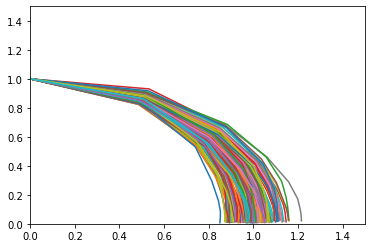

In [330]:
omega = 0.1
batch_size = 200
t_size = 10

sde = KineticBrownianHyperbolicPlane(omega)
ts = torch.linspace(0, 5., t_size)
y0 = torch.tensor([[0., 1., 1., 0.]]*batch_size)

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='srk')

for batch in range(batch_size):
    plt.plot(ys[:, batch, 0], ys[:, batch, 1])
    plt.xlim(0., 1.5)
    plt.ylim(0., 1.5)
plt.show()

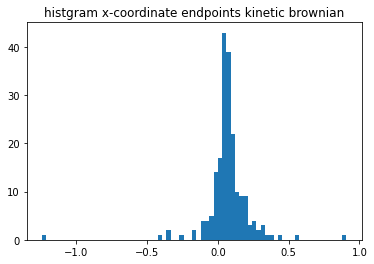

In [327]:
plt.hist(ys[-1,:,0].numpy(), bins='auto')
plt.title('histgram x-coordinate endpoints kinetic brownian')
plt.show()

In [328]:
print('mean  :', np.mean(ys[-1,:,0].numpy()))
print('median:', np.median(ys[-1,:,0].numpy()))
print('std   :', np.std(ys[-1,:,0].numpy()))

mean  : 0.06984634
median: 0.06525937
std   : 0.1586283
